## Business problem

Port terminals constantly strive to improve the efficiency of their operations through a careful
management of their berth facilities, machinery and personnel. 



The most important variables when planning terminal operations is knowing which vessels will arrive at the terminal and when.


MarineTraffic aims at being the best visibility providers by providing up to date vessel tracking data (using AIS), as well as additional derived information such as the estimated time of arrival (ETA) of a vessel to a port of interest.


AIS messages contain information on the port that the vessel is traveling to as well as the estimated time of arrival.

However, since ports may consist of more than one terminal, the exact terminal that the
vessel will visit is not known in advance making it difficult for MarineTraffic to assign future arrivals to terminals which, in turn, limits the ability to measure terminal congestion and calculate more accurate terminal arrival times.



A model which predicts the terminal a vessel will travel to has the potential to help all parties involved in a port call to plan their operations more effectively

# Data Description

A dataset has been extracted containing container calls at terminals that took place during the past 3
years for the Port of **Hamburg and Port of Los Angeles**. The dataset contains the following fields

A dataset has been extracted containing container calls at terminals that took place during the past 3
years for the Port of Hamburg and Port of Los Angeles. The dataset contains the following fields;


* **last_port**: Port where the *last* terminal call by vessel is recorded.



* **last_terminal**: The immediately previous *terminal* call of the vessel.


* **last_terminal_doc_timestamp**: Timestamp of previous terminal call.


* **current_port**: Port where the current terminal call by vessel is recorded.


* **current_terminal**: Current terminal call of the vessel.


* **shipname**: Name of the vessel.


* **dock_timestamp**: Timestamp of current terminal call.


* **GRT**: Vessel capacity (gross tonnage unit).


* **TEU**: Vessel capacity (twenty-foot equivalent Unit).


* **length**: Vessel length.


* **width**: Vessel width.

# Goals and Deliverable


The goal of this task is to implement & evaluate the accuracy of a solution that predicts the terminal
that a vessel will call.
**The product team claims that the history of terminals visited by a vessel in the past is a critical factor
that should be incorporated into the model**.

Some important steps that your solution would be expected to address and describe are the following:
* What features have you finally selected and engineered for your modeling approach? What led you to these choices? Why & how have you processed them?
* Which features seem to be the most important & how did you evaluate their importance?
* Do your findings agree with the product team’s insights discussed above? Before developing a ML model, how would you evaluate the importance/predictive power of one of the productidentified features as an independent variable?
* What type of prediction/training model have you chosen and why?
* How well does your predictive solution perform in terms of predicting the terminal a vessel will call?
* What different metrics/graphs can you use in order to understand when & why the algorithm fails/succeeds?
* What would be your baseline (i.e. a “naive” approach) to compare against?

# Solution Procedure

### problem understanding & EDA

In order to understand the problem we have to dive into the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

In [2]:
raw_data = pd.read_csv("data/mt_terminal_calls.csv")

In [3]:
raw_data.head(5)

,last_port,last_terminal,last_terminal_doc_timestamp,current_port,current_terminal,shipname,doc_timestamp,grt,teu,length,width
0,BREMERHAVEN,North Sea Terminal,2020-01-02 16:12:00.000,HAMBURG,Eurogate Container Terminal Hamburg,HEINRICH EHLER,2020-01-03 06:20:00.000,17488,1421,168.11,26.80
1,TILBURY,London Container Terminal,2020-01-01 21:56:00.000,HAMBURG,C. Steinweg Multipurpose Terminal,HENNEKE RAMBOW,2020-01-03 07:45:00.000,9981,868,134.40,22.74
2,ROTTERDAM MAASVLAKTE,Rotterdam World Gateway Terminal,2020-01-02 12:06:00.000,HAMBURG,HHLA Container Terminal Burchardkai,CMA CGM TANGER,2020-01-03 20:20:00.000,9966,1118,147.80,23.28
3,ROTTERDAM WAALHAVEN,RST Waalhaven,2020-01-01 16:05:00.000,HAMBURG,HHLA Container Terminal Burchardkai,NIEVES B,2020-01-03 20:28:00.000,10318,1036,151.72,23.40
4,GDYNIA,Gdynia Container Terminal,2020-01-01 14:45:00.000,HAMBURG,HHLA Container Terminal Burchardkai,JUDITH,2020-01-04 05:05:00.000,16023,1440,170.02,25.19


In order to make sense of the markets team claim of the historical importance of each ship,
is to check if any of those ships have actually performed a "full circle" from HAMBURG/LA to HAMBURG/LA

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12054 entries, 0 to 12053
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   last_port                    12054 non-null  object 
 1   last_terminal                12054 non-null  object 
 2   last_terminal_doc_timestamp  12054 non-null  object 
 3   current_port                 12054 non-null  object 
 4   current_terminal             12054 non-null  object 
 5   shipname                     12054 non-null  object 
 6   doc_timestamp                12054 non-null  object 
 7   grt                          12054 non-null  int64  
 8   teu                          12054 non-null  int64  
 9   length                       12054 non-null  float64
 10  width                        12054 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 1.0+ MB


In [5]:
# lets analyse the ports a bit


print(f'ships to HAMBURG : {raw_data.loc[raw_data["current_port"]=="HAMBURG",:].shape[0]}')
print(f'ships to LA : {raw_data.loc[raw_data["current_port"]!="HAMBURG",:].shape[0]}')


ships to HAMBURG : 9411
ships to LA : 2643


In [6]:
# i will create a new feature: a ratio of GRT/(length*width)

In [7]:
raw_data["diff"] = (pd.to_datetime(raw_data.loc[:, "doc_timestamp"]) - pd.to_datetime(raw_data.loc[:, "last_terminal_doc_timestamp"]))
raw_data["diff"] = raw_data.apply(lambda x: x['diff'].seconds,axis=1)

In [8]:
raw_data["ratio"] = raw_data.loc[:, "grt"]/(raw_data.loc[:,"width"]*raw_data.loc[:,"length"])

In [9]:
raw_data["size"] = raw_data.loc[:,"width"]*raw_data.loc[:,"length"]

<Axes: >

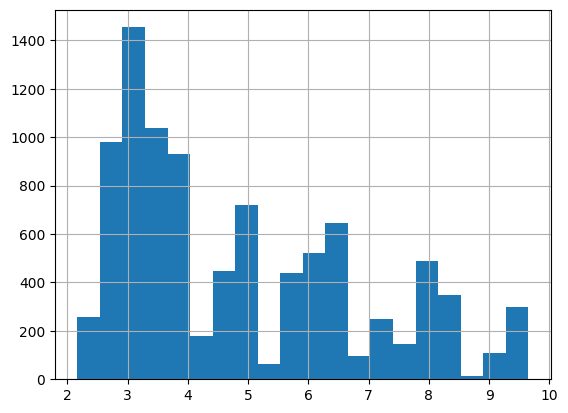

In [10]:
raw_data.loc[raw_data["current_port"]=="HAMBURG","ratio"].hist(bins=20)

<Axes: >

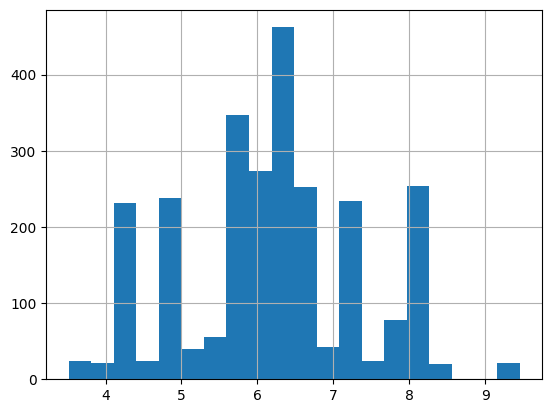

In [11]:
raw_data.loc[raw_data["current_port"]!="HAMBURG","ratio"].hist(bins=20)

<Axes: >

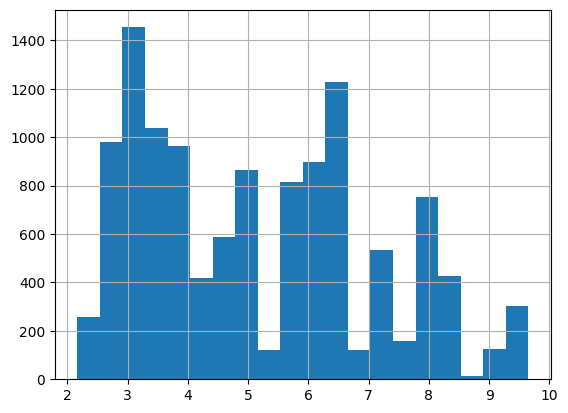

In [12]:
raw_data.loc[:,"ratio"].hist(bins=20)

<Axes: >

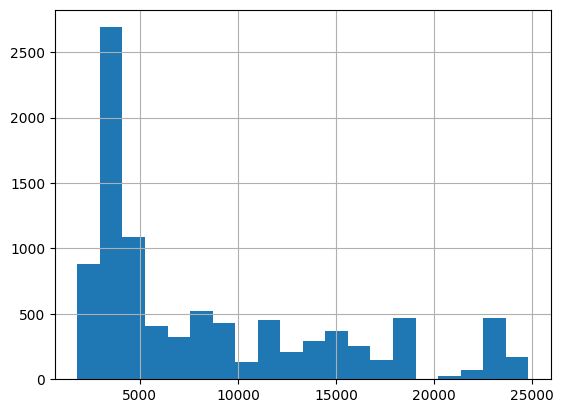

In [13]:
raw_data.loc[raw_data["current_port"]=="HAMBURG","size"].hist(bins=20)

<Axes: >

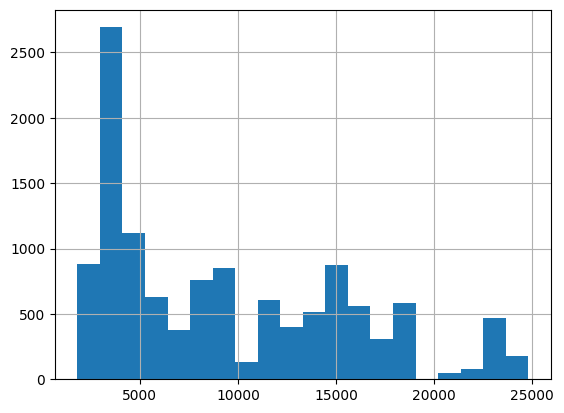

In [14]:
raw_data.loc[:,"size"].hist(bins=20)

<Axes: >

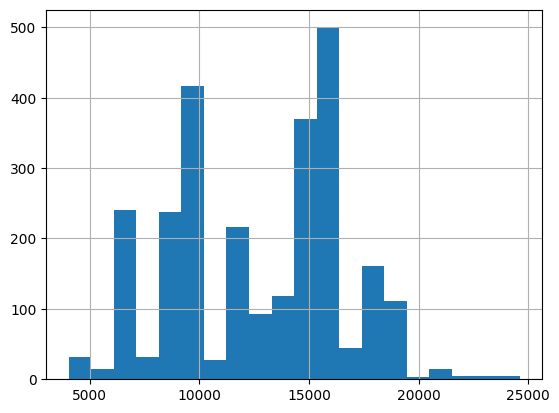

In [15]:
raw_data.loc[raw_data["current_port"]!="HAMBURG","size"].hist(bins=20)

In [16]:
raw_data.loc[raw_data["current_port"]!="HAMBURG",["size"]].describe()

,size
count,2643.000000
mean,12663.735663
std,3895.825909
min,4037.449600
25%,9470.020000
50%,14260.960000
75%,15489.600000
max,24609.846000


In [17]:
# clearly much different distribution per port

In [18]:
terminal_ham = raw_data.loc[raw_data["current_port"]=="HAMBURG", "current_terminal"].unique().tolist()

In [19]:
terminal_la = raw_data.loc[raw_data["current_port"]=="LOS ANGELES", "current_terminal"].unique().tolist()

In [20]:
def id2port(x, th, tl):
    if x["current_port"] == "HAMBURG":
        idx = th[x["current_terminal"]]
    else:
        idx = tl[x["current_terminal"]]
    return idx

In [21]:
terminal_ham = {i:idx for idx, i in enumerate(terminal_ham)}
terminal_la = {i:idx for idx, i in enumerate(terminal_la)}

raw_data["id_on_port"] =  raw_data.apply(id2port, args=(terminal_ham, terminal_la), axis=1)


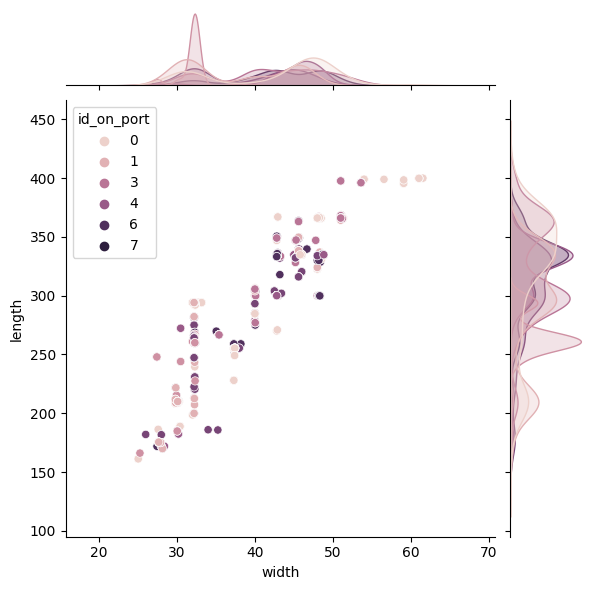

In [22]:
la_distribution = raw_data.loc[raw_data["current_port"]!="HAMBURG", ["width","length","size","id_on_port"]]
# Create hexbin plot with Seaborn
sns.jointplot(data=la_distribution, x="width",y="length",hue="id_on_port",)

# Show the plot
plt.show()

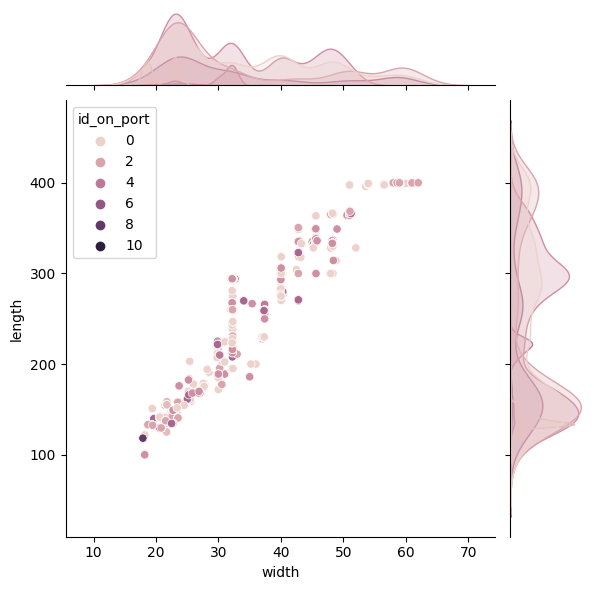

In [23]:
hamburg_distibution = raw_data.loc[raw_data["current_port"]=="HAMBURG", ["width","length","size","id_on_port"]]
# Create hexbin plot with Seaborn
sns.jointplot(data=hamburg_distibution, x="width",y="length",hue="id_on_port",  color="#4CB391")

# Show the plot
plt.show()

In [24]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12054 entries, 0 to 12053
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   last_port                    12054 non-null  object 
 1   last_terminal                12054 non-null  object 
 2   last_terminal_doc_timestamp  12054 non-null  object 
 3   current_port                 12054 non-null  object 
 4   current_terminal             12054 non-null  object 
 5   shipname                     12054 non-null  object 
 6   doc_timestamp                12054 non-null  object 
 7   grt                          12054 non-null  int64  
 8   teu                          12054 non-null  int64  
 9   length                       12054 non-null  float64
 10  width                        12054 non-null  float64
 11  diff                         12054 non-null  int64  
 12  ratio                        12054 non-null  float64
 13  size            

In [25]:
nu_cols = raw_data.select_dtypes(include=['float64','int64']).columns

In [26]:
nu_cols

Index(['grt', 'teu', 'length', 'width', 'diff', 'ratio', 'size', 'id_on_port'], dtype='object')

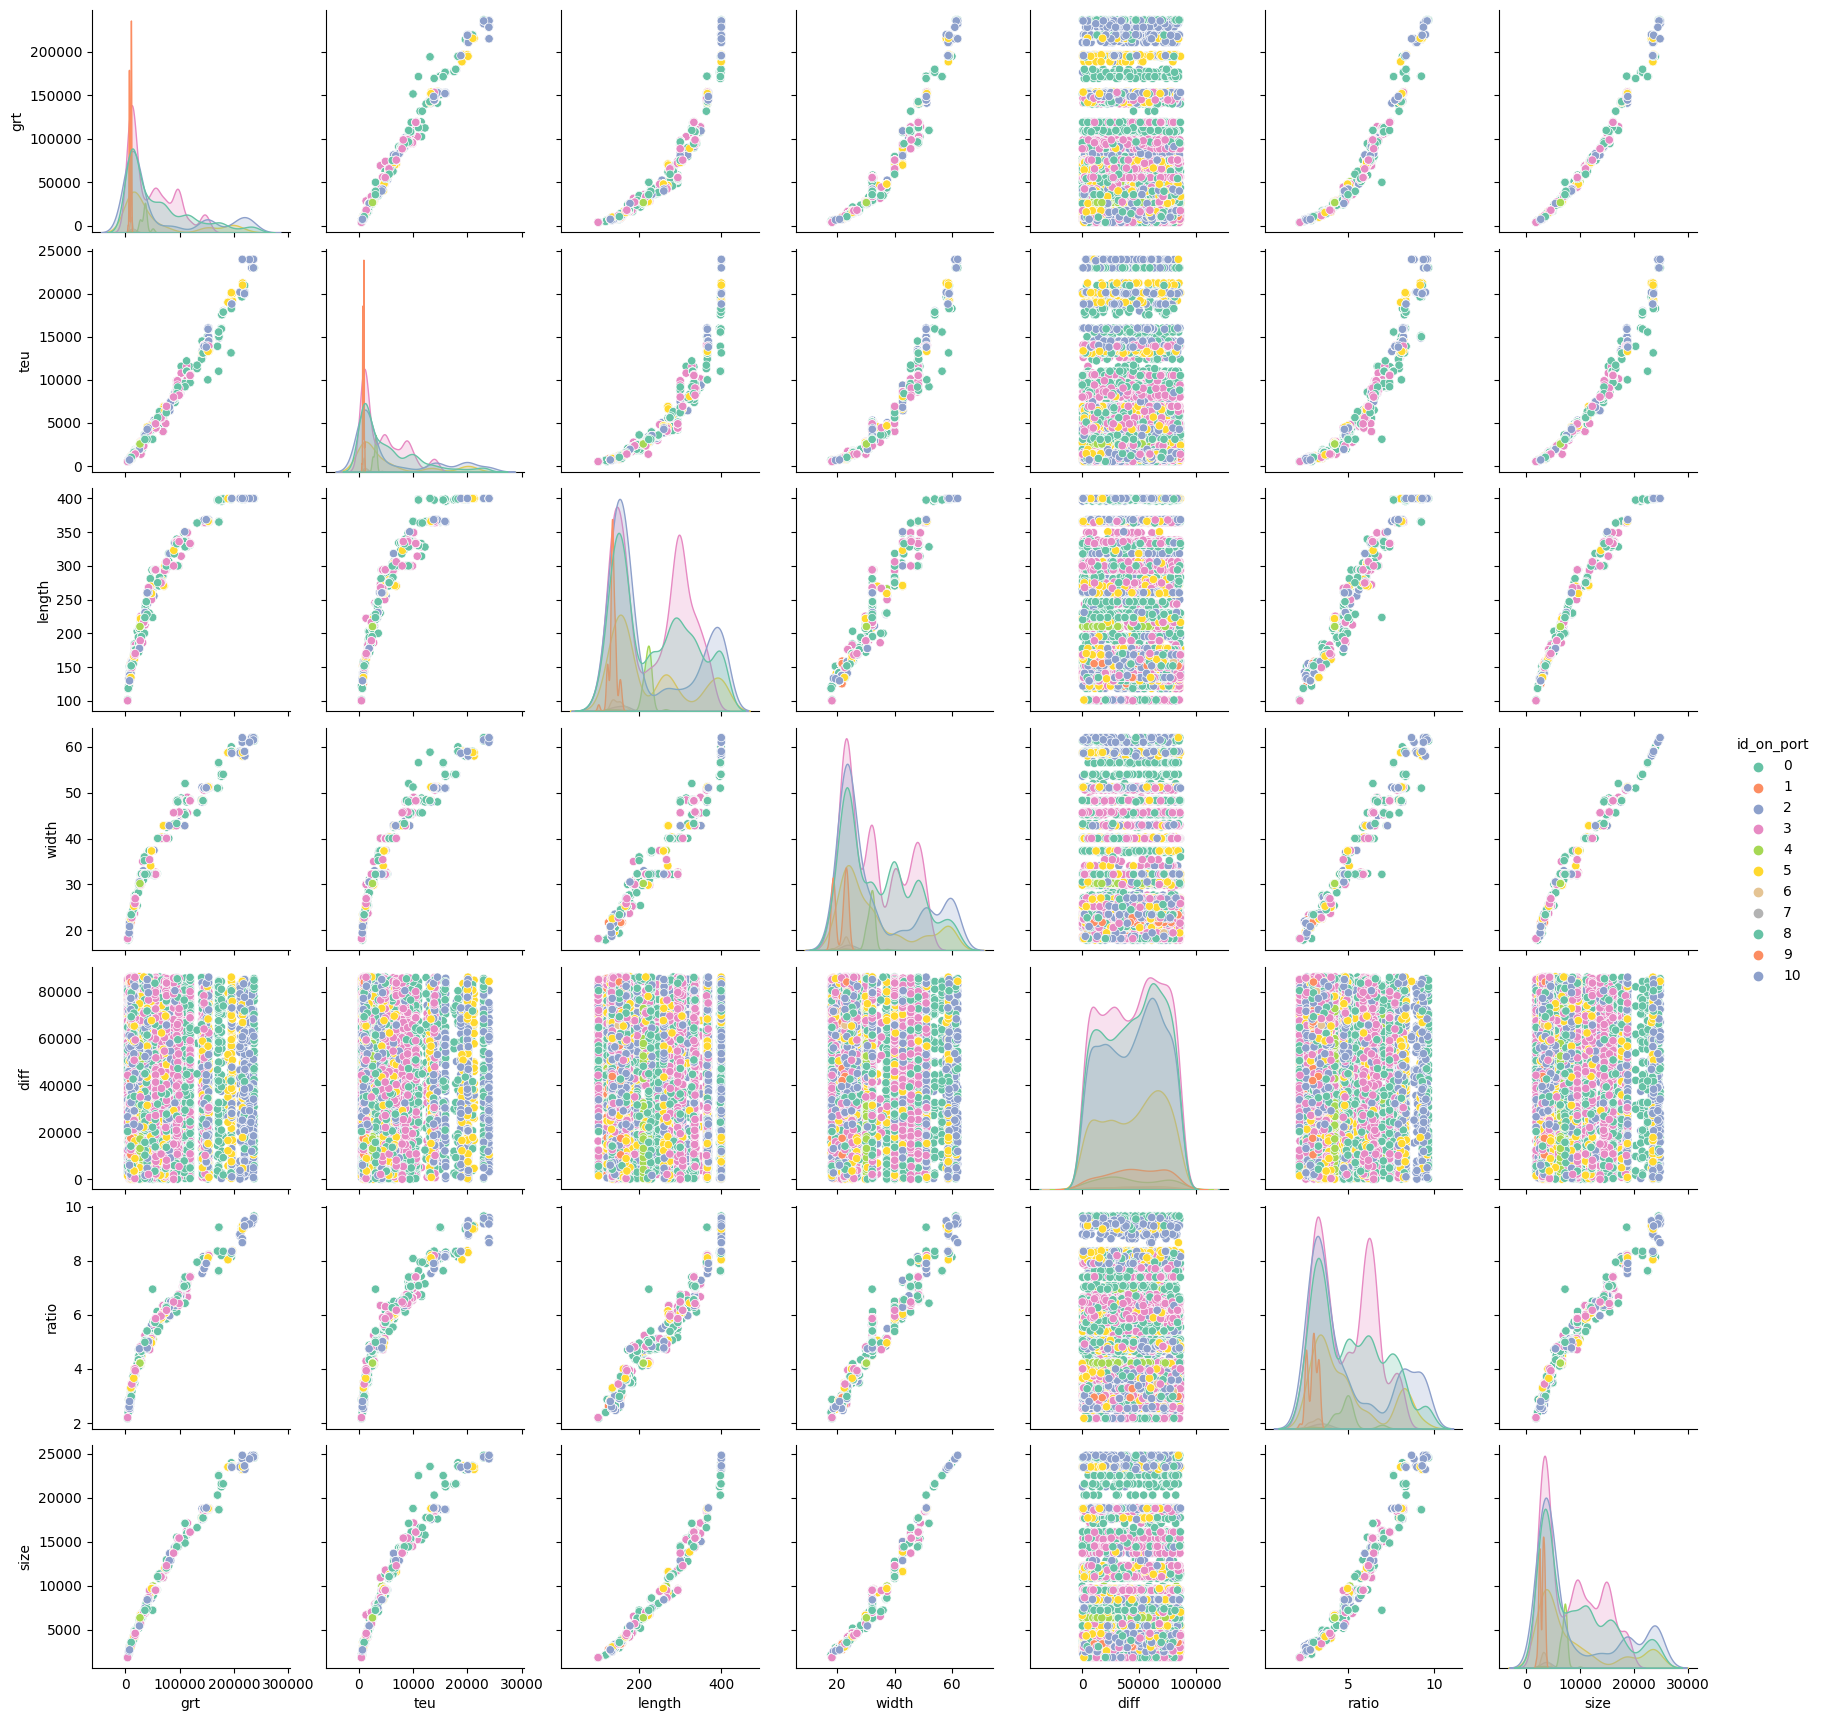

In [27]:
sns.pairplot(raw_data.loc[raw_data["current_port"]=="HAMBURG", nu_cols],hue="id_on_port", palette="Set2")

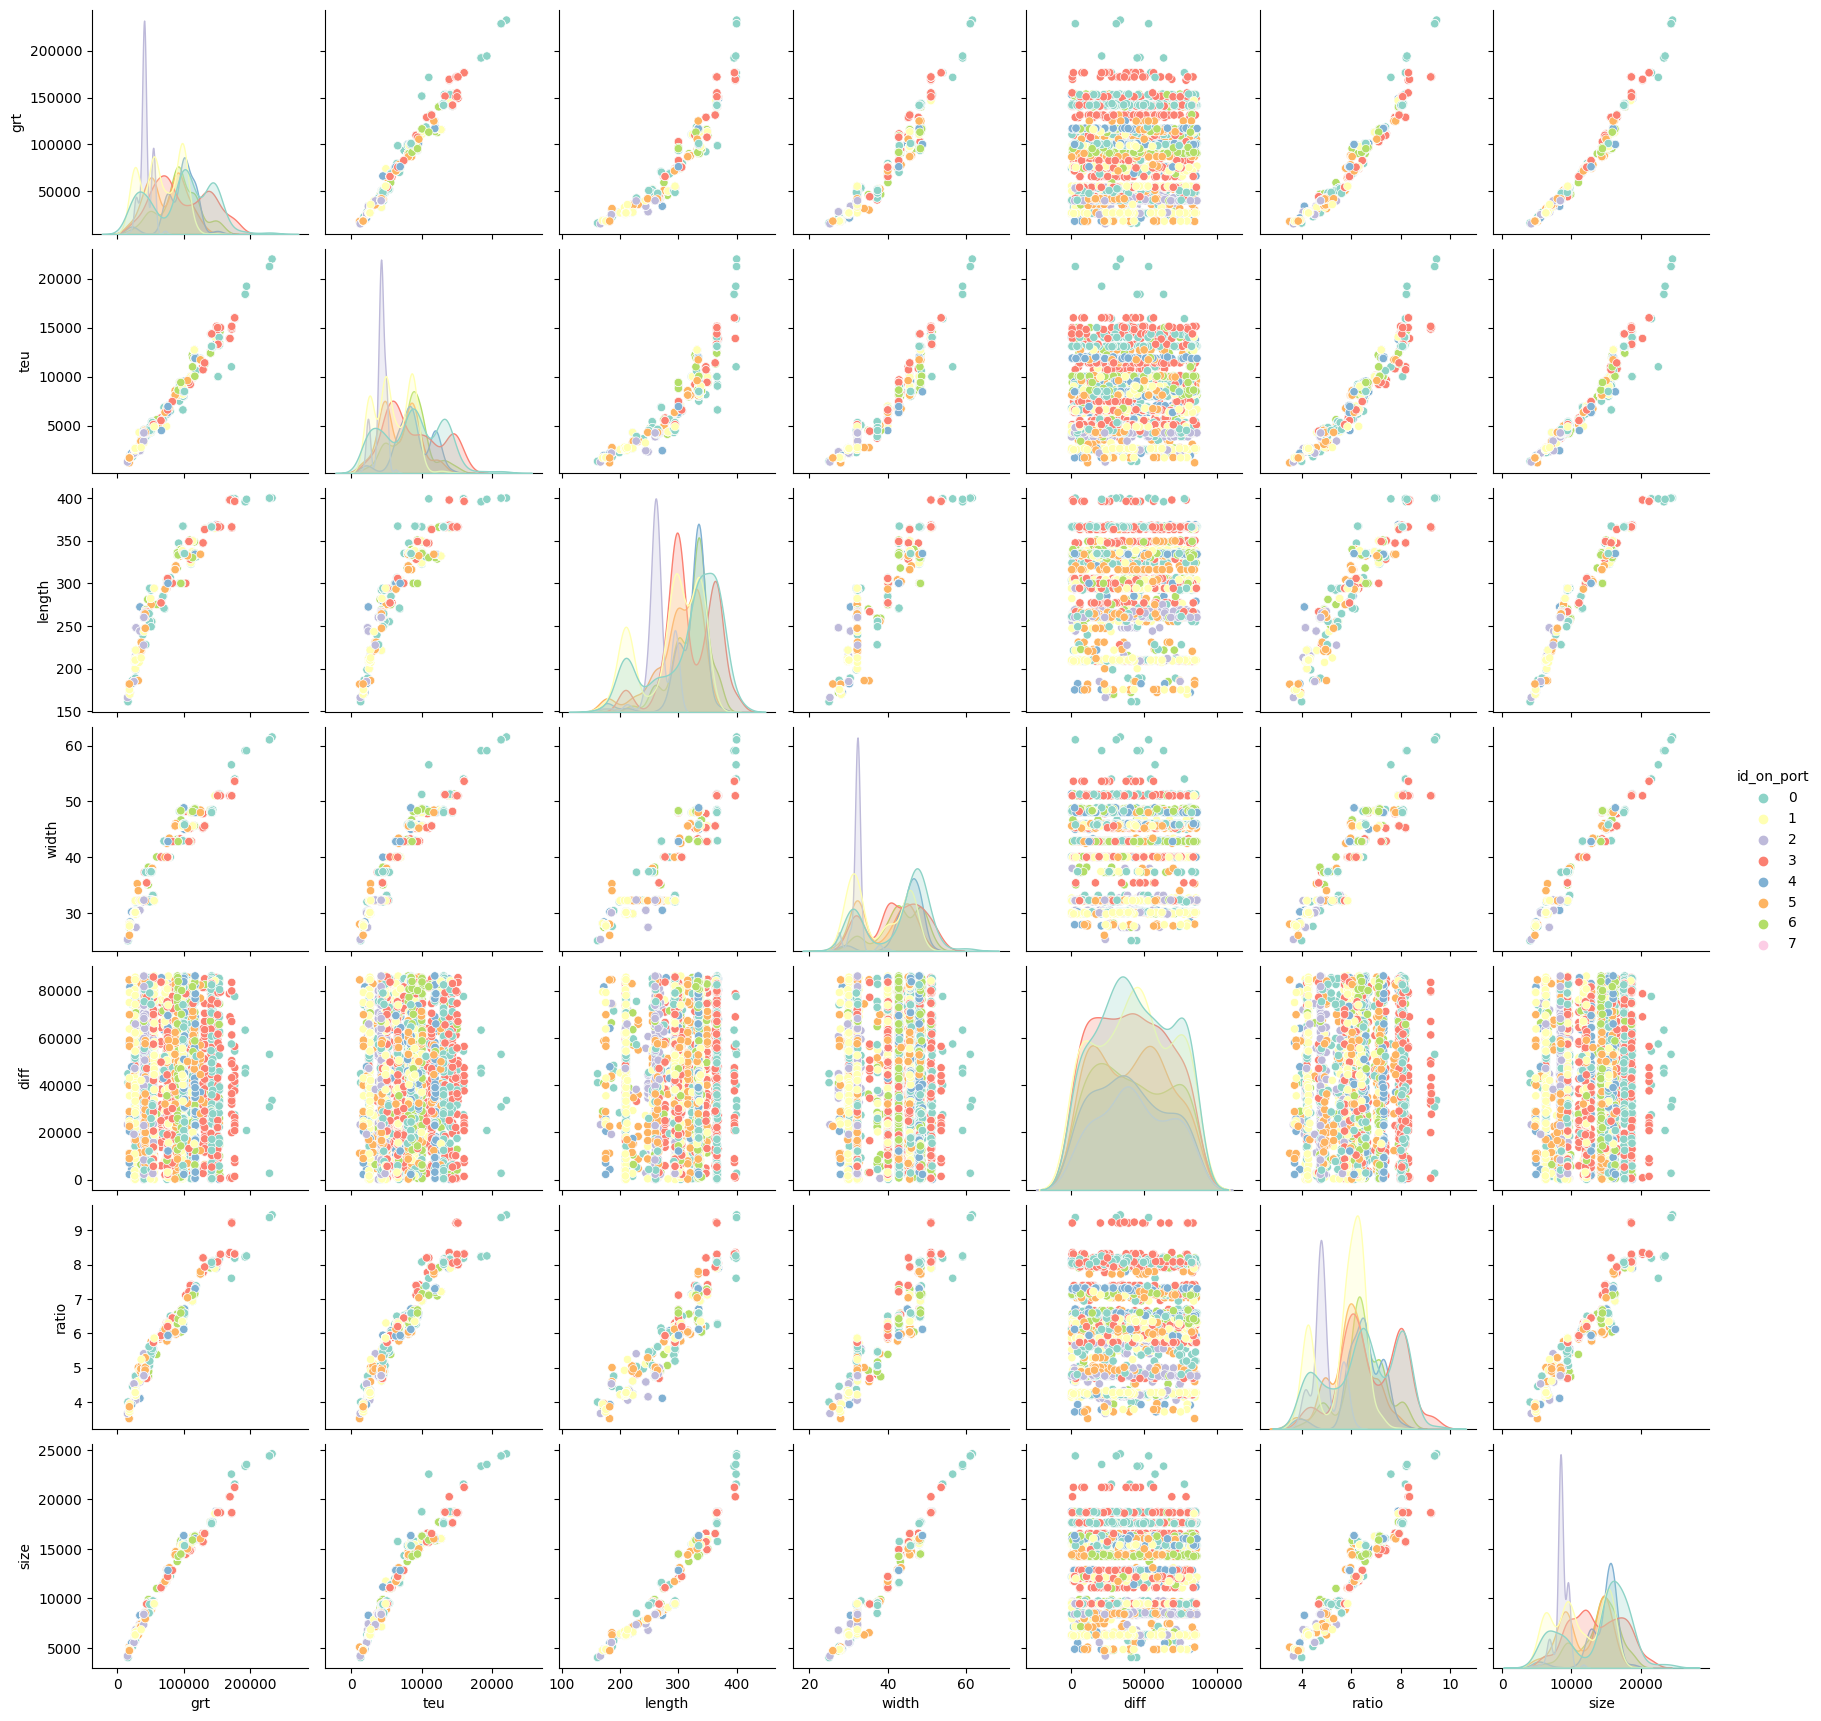

In [28]:
sns.pairplot(raw_data.loc[raw_data["current_port"]!="HAMBURG", nu_cols],hue="id_on_port", palette="Set3")

In [29]:
# Construct baseline

In [30]:
# use previous terminal as a prediction for the next

In [31]:
grouped_by_ship = raw_data.groupby(["shipname","current_port"])
restructure = []
matches = 0
for ship_no,(name,group) in enumerate(grouped_by_ship):
    restructure.append(group.sort_values(by="last_terminal_doc_timestamp"))
    restructure[-1].loc[:, "concat"] = restructure[-1].loc[:,"id_on_port"].astype(str) + restructure[-1].loc[:,"current_port"]
    restructure[-1].loc[:, "concat_s"] = restructure[-1].loc[:, "concat"].shift()
    tmp = restructure[-1].dropna()
    if tmp.dropna().shape[0]:
        matches += tmp.dropna().loc[restructure[-1]["concat"]==restructure[-1]["concat_s"], :].shape[0]
#         print(restructure[-1].loc[restructure[-1]["concat"]==restructure[-1]["concat_s"], ["concat","concat_s"]])
        

In [32]:
matches, raw_data.shape[0]

(7491, 12054)

In [33]:
matches/raw_data.shape[0]

0.6214534594325535

Micro F1 and Macro F1 scores are two commonly used metrics to evaluate the performance of a multi-class classification model.

Micro F1 score considers all the predictions and ground truth values from all classes, and gives an equal weight to each sample. This means that the overall F1 score is calculated by taking into account the total true positives, false positives, and false negatives across all classes. Micro F1 is useful when you want to put equal emphasis on each individual sample in the evaluation.

Macro F1 score, on the other hand, calculates the F1 score for each class and takes the unweighted mean of the F1 scores. In this case, each class is given equal importance, regardless of the number of samples in each class. Macro F1 is useful when you care about the overall performance of the model across all classes, rather than the performance on individual samples.

So, to summarize, if you want to put equal emphasis on each sample, use Micro F1. If you care about the overall performance of the model across all classes, use Macro F1.

In [34]:
restructure = pd.concat(restructure)

In [35]:
# this is a simple accuracy

In [36]:
population = Counter(restructure["concat"])

In [37]:
population

Counter({'4LOS ANGELES': 271,
         '5LOS ANGELES': 355,
         '1LOS ANGELES': 485,
         '0HAMBURG': 2574,
         '7HAMBURG': 28,
         '2HAMBURG': 2313,
         '5HAMBURG': 1183,
         '3HAMBURG': 2839,
         '6HAMBURG': 40,
         '9HAMBURG': 1,
         '1HAMBURG': 266,
         '3LOS ANGELES': 469,
         '6LOS ANGELES': 323,
         '2LOS ANGELES': 225,
         '0LOS ANGELES': 514,
         '8HAMBURG': 9,
         '4HAMBURG': 157,
         '10HAMBURG': 1,
         '7LOS ANGELES': 1})

It is evident that we have somewhat of a majority classifier in our hands so it would be more accurate to use macro
instead of micro F1 here. Since we do want to give each terminal the same opportunity

In [38]:
print(restructure.shape[0])

12054


In [39]:
from sklearn.metrics import f1_score

In [40]:
restructure.loc[restructure["concat_s"].isna(), "concat_s"] = "   "

In [41]:
f1_score(restructure["concat"], restructure["concat_s"],average='macro' )

0.4796832295743413

In [42]:
f1_score(restructure["concat"], restructure["concat_s"],average='micro' )

0.6214534594325535

This is the first and extremely naive baseline since it does not take into account the prior knowledge of the port

In [43]:
raw_data

,last_port,last_terminal,last_terminal_doc_timestamp,current_port,current_terminal,shipname,doc_timestamp,grt,teu,length,width,diff,ratio,size,id_on_port
0,BREMERHAVEN,North Sea Terminal,2020-01-02 16:12:00.000,HAMBURG,Eurogate Container Terminal Hamburg,HEINRICH EHLER,2020-01-03 06:20:00.000,17488,1421,168.11,26.80,50880,3.881609,4505.3480,0
1,TILBURY,London Container Terminal,2020-01-01 21:56:00.000,HAMBURG,C. Steinweg Multipurpose Terminal,HENNEKE RAMBOW,2020-01-03 07:45:00.000,9981,868,134.40,22.74,35340,3.265760,3056.2560,1
2,ROTTERDAM MAASVLAKTE,Rotterdam World Gateway Terminal,2020-01-02 12:06:00.000,HAMBURG,HHLA Container Terminal Burchardkai,CMA CGM TANGER,2020-01-03 20:20:00.000,9966,1118,147.80,23.28,29640,2.896433,3440.7840,2
3,ROTTERDAM WAALHAVEN,RST Waalhaven,2020-01-01 16:05:00.000,HAMBURG,HHLA Container Terminal Burchardkai,NIEVES B,2020-01-03 20:28:00.000,10318,1036,151.72,23.40,15780,2.906276,3550.2480,2
4,GDYNIA,Gdynia Container Terminal,2020-01-01 14:45:00.000,HAMBURG,HHLA Container Terminal Burchardkai,JUDITH,2020-01-04 05:05:00.000,16023,1440,170.02,25.19,51600,3.741241,4282.8038,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,ANTWERP,MSC PSA Delwaidedok Terminal,2022-11-21 18:24:00.000,HAMBURG,Eurogate Container Terminal Hamburg,CMA CGM LOME,2022-11-24 14:20:00.000,39753,3100,228.15,32.25,71760,5.402810,7357.8375,0
12050,ROTTERDAM MAASVLAKTE,APM Maasvlakte 2,2022-11-22 16:16:00.000,HAMBURG,Eurogate Container Terminal Hamburg,SAFMARINE BENGUELA,2022-11-24 20:38:00.000,35835,3078,223.30,32.20,15720,4.983825,7190.2600,0
12051,BREMERHAVEN,MSC Gate,2022-11-22 04:50:00.000,HAMBURG,HHLA Container Terminal Altenwerder,CONTAINERSHIPS STELLAR,2022-11-24 21:20:00.000,17982,1380,169.95,26.90,59400,3.933368,4571.6550,3
12052,VUOSAARI,Vuosaari Harbour,2022-11-21 03:41:00.000,HAMBURG,Eurogate Container Terminal Hamburg,ELBWIND,2022-11-24 22:56:00.000,10585,1000,151.72,23.40,69300,2.981482,3550.2480,0
